## Install Libraries and Dependencies

In [2]:
import cv2  # OpenCV library for video processing
import torch  # PyTorch library for deep learning
import os  # For file and directory manipulation
import numpy as np  # Numerical computing library
from typing import List  # Type hinting for clarity
from matplotlib import pyplot as plt  # For visualization
import imageio  # For creating GIFs
import gdown  # For downloading data from Google Drive
from torch.utils.data import Dataset, DataLoader  # For creating data loaders
import torch.nn as nn  # Neural network modules
import torch.optim as optim  # Optimization algorithms
from torchvision import datasets, transforms  # Image and video transformations
import torch.nn.functional as F  # Functional interface for neural network operations
from torch.nn.utils.rnn import pad_sequence  # Padding for sequencesF

# Set device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Connecting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Extracting Files From Previously Downloaded Data (needed for google colab)
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=2b699dd7-c0b8-4421-b9a5-e796aeb71549
To: /content/data.zip
100%|██████████| 423M/423M [00:02<00:00, 196MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

# Data Loading and Helper Functions

In [4]:
# Helper class for character mapping including encoding and decoding character strings
class CharMap:
    def __init__(self):
        self.vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "] + ["<pad>"]
        self.char_to_num = {char: num for num, char in enumerate(self.vocab)}
        self.num_to_char = {num: char for char, num in self.char_to_num.items()}
        self.pad_token_idx = self.char_to_num["<pad>"]  # Store the index of the <pad> token

    def encode(self, text):
        return [self.char_to_num[char] for char in text if char in self.char_to_num]

    def decode(self, indices):
        # Decode, ignoring indices corresponding to <pad>
        return ''.join(self.num_to_char[idx] for idx in indices if idx != self.pad_token_idx)

char_map = CharMap()

In [5]:
# Function to load and preprocess video frames
def load_video(path: str) -> torch.Tensor:
    """
    Loads a video file, preprocesses the frames, and returns a PyTorch tensor of normalized frames.
    """
    cap = cv2.VideoCapture(path)  # Open the video file
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):  # Iterate over frames
        ret, frame = cap.read()  # Read a frame
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        frames.append(frame[190:236, 80:220])  # Crop region of interest
    cap.release()  # Release the video capture object

    frames = torch.tensor(frames, dtype=torch.float32)  # Convert frames to PyTorch tensor
    mean = frames.mean()  # Calculate mean
    std = frames.std()  # Calculate standard deviation
    return (frames - mean) / std  # Normalize pixel values

# Function to load and process alignment files
def load_alignments(path: str) -> torch.Tensor:  # Changed return type to torch.Tensor
    """
    Loads alignments from a file and converts them to a PyTorch tensor of character indices.
    """
    with open(path, 'r') as f:
        lines = f.readlines()  # Read all lines from the alignment file
    tokens = []
    for line in lines:
        line = line.split()  # Split the line into words
        if line[2] != 'sil':  # Check if the word is not silence ('sil')
            tokens.extend([' ', line[2]])  # Add a space and the word to the tokens list
    tokens = [char for token in tokens for char in token]  # Flatten the list of tokens
    indices = [char_map.char_to_num[char] for char in tokens[1:]]  # Convert characters to numerical indices
    return torch.tensor(indices, dtype=torch.long)  # Return a PyTorch tensor of indices

In [6]:
# Function to load both video and alignment data
def load_data(path: str):
    """
    Loads video frames and alignments from the specified path.
    """
    file_name = os.path.splitext(os.path.basename(path))[0]  # Extract filename without extension
    video_path = os.path.join('data', 's1', f'{file_name}.mpg')  # Construct video path
    alignment_path = os.path.join('data', 'alignments', 's1', f'{file_name}.align')  # Construct alignment path

    if os.path.exists(alignment_path):  # Check if alignment file exists
        frames = load_video(video_path)  # Load video frames
        alignments = load_alignments(alignment_path)  # Load alignments
        return frames, alignments
    else:
        return None

# Testing if Data was loaded as expected and the tensors are correct size.
# test_path = "/content/data/s1/bbaf3s.mpg"
# frames, alignments = load_data(test_path)
# plt.imshow(frames[35].cpu().numpy(), cmap='gray')
# plt.show()
# print(alignments.size())
# print(frames.size())
# print(''.join([char_map.num_to_char[num.item()] for num in alignments]))

In [7]:
# Dataset class for lip reading data
class LipReadingDataset(Dataset):
    def __init__(self, file_paths):
        self.file_paths = file_paths  # Store list of file paths

    def __len__(self):
        return len(self.file_paths)  # Return the number of data samples

    def __getitem__(self, index):
        path = self.file_paths[index]  # Get file path for the given index
        data = load_data(path)  # Load data (frames and alignments)
        if data is not None:
            frames, alignments = data
            return frames, alignments
        else:
            return self.__getitem__(index + 1)  # If data is None, try the next index

        return video, alignment

from torch.nn.utils.rnn import pad_sequence

# Collate function to add padding to both frames and alignments tensors
def collate_fn(batch):
    videos, alignments = zip(*batch)
    # Convert list of arrays or tensors to padded tensor
    # Use .clone().detach() to safely create a new tensor detached from the computation graph
    padded_videos = pad_sequence([v.clone().detach() if isinstance(v, torch.Tensor) else torch.tensor(v) for v in videos], batch_first=True)
    padded_alignments = pad_sequence([a.clone().detach() if isinstance(a, torch.Tensor) else torch.tensor(a) for a in alignments], batch_first=True, padding_value=char_map.char_to_num["<pad>"])
    return padded_videos, padded_alignments

In [8]:
import torch
from textblob import TextBlob

## Create Function to convert predictions from Model into character strings without padding
def decode_predictions(output, char_map):
    # Apply softmax to convert logits to probabilities
    probabilities = F.softmax(output, dim=2)
    # Use argmax to get the most likely character indices
    max_indices = torch.argmax(probabilities, dim=2)
    batch_size = max_indices.size(0)
    pad_token_idx = char_map.char_to_num["<pad>"]  # Get the index for the pad token

    # Decode each sequence in the batch, ignoring pad characters
    decoded_batch = []
    for i in range(batch_size):
        decoded_text = ''.join([char_map.num_to_char[idx.item()] for idx in max_indices[i] if idx.item() != pad_token_idx])
        decoded_batch.append(decoded_text)

    return decoded_batch

def clean_and_correct_text(text):
    # Correct spelling using TextBlob
    blob = TextBlob(text)
    corrected_text = str(blob.correct())

    # Tokenize the corrected text and normalize whitespace
    tokens = corrected_text.split()

    # Concatenate tokens until the 30 character limit is reached
    result_text = ""
    for token in tokens:
        if len(result_text) + len(token) + 1 > 31:  # +1 for the space
            break
        result_text += (token + " ")

    return result_text.strip()

# Testing

<ipython-input-5-a0f209aa9a03>:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  frames = torch.tensor(frames, dtype=torch.float32)  # Convert frames to PyTorch tensor


Frames shape: torch.Size([2, 75, 46, 140])
Alignments shape: torch.Size([2, 24])
[11, 0, 24, 38, 6, 17, 4, 4, 13, 38, 0, 19, 38, 11, 38, 4, 8, 6, 7, 19, 38, 13, 14, 22]
lay green at l eight now


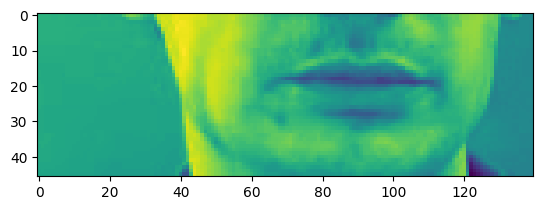

In [9]:
## Read all file names from the Data directory
data_dir = 'data/s1/'
file_paths = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.mpg')]
dataset = LipReadingDataset(file_paths)

# ## Create Train Test Split
# train_size = int(0.9 * len(dataset))
# test_size = len(dataset) - train_size
# train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

## Decides the number of channels in each tensor
batch_size = 2  # Setting the batch size
test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)


# Test if padding worked as expected and all tensors are of uniform size
batch = next(iter(test_loader))
frames, alignments = batch
print(f"Frames shape: {frames.shape}")
print(f"Alignments shape: {alignments.shape}")

# Visualize the first frame of the first video in the batch
# Print the alignments for the sample video
sample_alignments = alignments[0].tolist()
print(sample_alignments)
print(char_map.decode(sample_alignments))
plt.imshow(frames[0][74].cpu().numpy())

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import csv

class LipNetModel(nn.Module):
    def __init__(self, num_classes):
        super(LipNetModel, self).__init__()
        self.conv1 = nn.Conv3d(1, 128, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool3d((1, 2, 2))

        self.conv2 = nn.Conv3d(128, 256, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool3d((1, 2, 2))

        self.conv3 = nn.Conv3d(256, 75, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool3d((1, 2, 2))

        # Adjust the GRU layers to not use dropout internally since they have only one layer
        self.gru1 = nn.GRU(6375, 128, num_layers=1, batch_first=True, bidirectional=True)
        self.dropout1 = nn.Dropout(0.5)  # Add dropout layer manually after the first GRU
        self.gru2 = nn.GRU(256, 128, num_layers=1, batch_first=True, bidirectional=True)
        self.dropout2 = nn.Dropout(0.5)  # Add dropout layer manually after the second GRU

        self.fc = nn.Linear(256, num_classes)  # Output layer to number of classes

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        # Flatten the features into [batch, seq_len, feature]
        x = x.view(x.size(0), x.size(2), -1)

        x, _ = self.gru1(x)
        x = self.dropout1(x)  # Apply dropout after the first GRU
        x, _ = self.gru2(x)
        x = self.dropout2(x)  # Apply dropout after the second GRU
        x = self.fc(x)

        return x

# Testing loop (over entire dataset)

In [15]:
# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create instance of the model
model = LipNetModel(num_classes=len(char_map.vocab)).to(device)

# Loading from google drive since using google colab
# Check if CUDA is available
if torch.cuda.is_available():
    # Load the model state dict on the GPU
    model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/model_1_checkpoints/2_lip_reading_model_100.pth', map_location=torch.device('cuda')))
    print("Model loaded on GPU")
else:
    # If CUDA is not available, load on CPU instead
    model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/model_1_checkpoints/2_lip_reading_model_100.pth', map_location=torch.device('cpu')))
    print("CUDA is not available. Model loaded on CPU")

# ## Loading from repository directly
# model.load_state_dict(torch.load('/Model_Checkpoints/lip_nn_model_post_100_epoch.pth'))

Model loaded on GPU


In [14]:
# pip install python-Levenshtein

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 38.7 MB/s eta 0:00:00


In [16]:
import torch
from torch.nn import functional as F
import Levenshtein as lv  # Levenshtein package for edit distance calculation
import csv

def test_model(test_loader, model, char_map):
    model.eval()
    test_results = []
    iteration_number = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.unsqueeze(1).to(device)  # Ensure input dimensions and device are correct
            outputs = model(inputs)

            # Decode outputs to text without padding
            decoded_texts = decode_predictions(outputs, char_map)
            # Post-process decoded texts
            post_processed_texts = [clean_and_correct_text(text) for text in decoded_texts]

            # Retrieve original texts from labels
            original_texts = [char_map.decode(label.tolist()) for label in labels]

            # Calculate metrics and print results
            for original, decoded, post_processed in zip(original_texts, decoded_texts, post_processed_texts):
                raw_edit_distance = lv.distance(original, decoded)
                post_processed_edit_distance = lv.distance(original, post_processed)
                test_results.append({
                    'iteration': iteration_number,
                    'original_text': original,
                    'raw_prediction': decoded,
                    'post_processed_prediction': post_processed,
                    'raw_edit_distance': raw_edit_distance,
                    'post_processed_edit_distance': post_processed_edit_distance
                })

                # Print the iteration details
                print(f"Iteration {iteration_number}:")
                print(f"Original Text: {original}")
                print(f"Post-Processed Prediction: {post_processed}")
                print(f"Post-Processed Edit Distance: {post_processed_edit_distance}")
                print("-" * 50)  # Separator for clarity

                iteration_number += 1

                # Save results to CSV every 100 iterations
                if iteration_number % 100 == 0:
                    with open(f'LipReading_nn_{iteration_number}_predictions.csv', 'w', newline='') as file:
                        writer = csv.DictWriter(file, fieldnames=test_results[0].keys())
                        writer.writeheader()
                        writer.writerows(test_results)

    # Ensure remaining results are written to file
    if test_results:
        with open(f'LipReading_nn_{iteration_number}_predictions.csv', 'w', newline='') as file:
            writer = csv.DictWriter(file, fieldnames=test_results[0].keys())
            writer.writeheader()
            writer.writerows(test_results)

    return None  # Depending on use, might not need to return anything

Iteration 0:
Original Text: lay green at l eight now
Post-Processed Prediction: lay green at l eight now in
Post-Processed Edit Distance: 3
--------------------------------------------------
Iteration 1:
Original Text: bin white in s nine soon
Post-Processed Prediction: bin white in v nine soon
Post-Processed Edit Distance: 1
--------------------------------------------------
Iteration 2:
Original Text: set red at h four now
Post-Processed Prediction: set red at u four now no oe
Post-Processed Edit Distance: 7
--------------------------------------------------
Iteration 3:
Original Text: set blue in g five soon
Post-Processed Prediction: set blue in a five sown ni in
Post-Processed Edit Distance: 8
--------------------------------------------------
Iteration 4:
Original Text: bin red by g four please
Post-Processed Prediction: bin red by a four please nine
Post-Processed Edit Distance: 6
--------------------------------------------------
Iteration 5:
Original Text: lay red by r six ple

TypeError: 'NoneType' object is not iterable

In [18]:
import csv
# Function toload edit distances from CSV or test results
def load_test_results_from_csv(file_path):
    # Initialize an empty list to store the test results
    test_results = []

    # Open the CSV file and read data into the list of dictionaries
    with open(file_path, mode='r', newline='') as file:
        reader = csv.DictReader(file)
        for row in reader:
            # Convert numeric fields from string to appropriate types
            row['raw_edit_distance'] = int(row['raw_edit_distance'])
            row['post_processed_edit_distance'] = int(row['post_processed_edit_distance'])
            test_results.append(row)

    return test_results

# Function to compute average edit distance and other metrics
def compute_metrics(test_results):
    total_raw_edit_distance = sum(result['raw_edit_distance'] for result in test_results)
    total_post_processed_edit_distance = sum(result['post_processed_edit_distance'] for result in test_results)
    num_samples = len(test_results)
    average_raw_edit_distance = total_raw_edit_distance / num_samples
    average_post_processed_edit_distance = total_post_processed_edit_distance / num_samples

    print("Average Raw Edit Distance:", average_raw_edit_distance)
    print("Average Post-Processed Edit Distance:", average_post_processed_edit_distance)

# Load test results from CSV
file_path = 'LipReading_nn_1000_predictions.csv'
test_results = load_test_results_from_csv(file_path)

# Compute metrics with the loaded test results
compute_metrics(test_results)


Average Raw Edit Distance: 16.106
Average Post-Processed Edit Distance: 4.887


In [19]:
import csv

def load_data_from_csv(file_path):
    with open(file_path, mode='r', newline='') as file:
        reader = csv.DictReader(file)
        return list(reader)

def calculate_word_accuracy(test_results):
    word_accuracies = []

    for result in test_results:
        original_words = set(result['original_text'].split())
        predicted_words = set(result['post_processed_prediction'].split())

        # Calculate the number of common words
        common_words = original_words.intersection(predicted_words)
        num_common_words = len(common_words)
        total_words_in_original = len(original_words)

        # Avoid division by zero
        if total_words_in_original > 0:
            accuracy = num_common_words / total_words_in_original
        else:
            accuracy = 0.0  # Can consider it as perfect match if no words to predict

        word_accuracies.append({
            'original_text': result['original_text'],
            'predicted_text': result['post_processed_prediction'],
            'common_word_count': num_common_words,
            'total_original_words': total_words_in_original,
            'word_accuracy': accuracy
        })

        # Optionally print each comparison's details
        print(f"Original: {result['original_text']}")
        print(f"Predicted: {result['post_processed_prediction']}")
        print(f"Word Accuracy: {accuracy:.2f}")
        print('-' * 50)

    return word_accuracies

# Path to your CSV file
file_path = 'LipReading_nn_1000_predictions.csv'
test_results = load_data_from_csv(file_path)
word_accuracies = calculate_word_accuracy(test_results)

# If you need to see the average accuracy
average_accuracy = sum(item['word_accuracy'] for item in word_accuracies) / len(word_accuracies)
print(f"Average Word Accuracy: {average_accuracy:.2f}")

Original: lay green at l eight now
Predicted: lay green at l eight now in
Word Accuracy: 1.00
--------------------------------------------------
Original: bin white in s nine soon
Predicted: bin white in v nine soon
Word Accuracy: 0.83
--------------------------------------------------
Original: set red at h four now
Predicted: set red at u four now no oe
Word Accuracy: 0.83
--------------------------------------------------
Original: set blue in g five soon
Predicted: set blue in a five sown ni in
Word Accuracy: 0.67
--------------------------------------------------
Original: bin red by g four please
Predicted: bin red by a four please nine
Word Accuracy: 0.83
--------------------------------------------------
Original: lay red by r six please
Predicted: lay reed by e side paeaaas
Word Accuracy: 0.33
--------------------------------------------------
Original: place blue by c five soon
Predicted: place blue by y five soon
Word Accuracy: 0.83
------------------------------------------

In [20]:
import csv

def load_and_modify_csv(file_path):
    data = []
    with open(file_path, mode='r', newline='') as file:
        reader = csv.DictReader(file)
        for row in reader:
            data.append(row)

    return data

def calculate_and_add_word_coverage(data):
    for row in data:
        original_words = set(row['original_text'].split())
        predicted_words = set(row['post_processed_prediction'].split())

        # Calculate the number of common words
        common_words = original_words.intersection(predicted_words)
        num_common_words = len(common_words)
        total_words_in_original = len(original_words)

        # Calculate word accuracy
        if total_words_in_original > 0:
            word_coverage = num_common_words / total_words_in_original
        else:
            word_coverage = 0.0  # Can consider it as perfect match if no words to predict

        # Add the word accuracy to the row
        row['word_coverage'] = word_coverage

    return data

def write_data_to_csv(data, output_file_path):
    if data:
        fieldnames = data[0].keys()  # Extract fieldnames from the first row dictionary
        with open(output_file_path, 'w', newline='') as file:
            writer = csv.DictWriter(file, fieldnames=fieldnames)
            writer.writeheader()
            writer.writerows(data)

# Path to your CSV file and output file path
input_file_path = 'LipReading_nn_1000_predictions.csv'
output_file_path = 'LipReading_nn_1000_predictions_updated.csv'

# Load data, calculate word coverage, and write to a new CSV
data = load_and_modify_csv(input_file_path)
data_with_coverage = calculate_and_add_word_coverage(data)
write_data_to_csv(data_with_coverage, output_file_path)

print("Updated CSV with word coverage has been written to:", output_file_path)

Updated CSV with word coverage has been written to: LipReading_nn_1000_predictions_updated.csv
